# Proceso de aumentacion de respuestas al impulso 
Herramientas para analizar la distribucion en TR y DRR de los impulsos existentes, y aumentacion de estos para conformar una base de datos mas homogenea en estos descriptores. 

Dado un impulso, primero se aplican las transformaciones temporales, luego todas las de amplitud. El JND del tiempo de reverberacion es 0.2*TR lo que da un total de 118 TRs para el rango [0.1 , 1]

### POR HACER: 
    
    -VER QUE PASA EN LA CONCATENACION FINAL QUE HAGO CUANDO CAMBIO EL TIEMPO DE REVERBERACION. TENGO QUE TENER CUIDADO DE NO ESTAR METIENDO DISTROSION AHI.
    
    -HACER UNA FUNCION PROPIA QUE CALCULE EL TR PARA PODER TRABAJAR TODO CON ARRAYS Y NO CON PATHS

In [1]:
import tqdm
import acoustics
import librosa
import numpy as np 
import matplotlib.pyplot as plt 
import soundfile as sf
from tr_augmentation import tr_augmentation, get_audio_list
from drr_augmentation import *
from tr_mid import t60_impulse_array

rir_path = '/mnt/datasets/impulsos/reales/C4DM'
rir_list = get_audio_list(rir_path)

def impulse_info(array, fs):
    """Calcula el TRmid (promedio entre bandas de 500 y 1000 Hz) y la relacion
    directo reverberado para una respuesta al impulso 
    """
    #Tiempo de reverberacion
    tr_mid = t60_impulse_array(array, fs).mean()

    #Relacion directo-reverberado
    DRR, _, _ = get_DRR(array, fs)
    
    return tr_mid, DRR

# Base de datos de entrada

Primero hago una evaluacion de los tiempos de reverberacion y las relaciones directo-reverberado que tengo en la base de datos de impulsos reales incial. 

In [2]:
tr_list=[]
drr_list=[]
room = []

for impulso in tqdm.tqdm(rir_list):
    rir, fs = librosa.load(impulso, sr=16000)
    tr, drr = impulse_info(rir, fs)
    tr_list.append(tr)
    drr_list.append(drr)
    room.append(impulso.split('/')[-3])

100%|██████████| 638/638 [01:22<00:00,  7.72it/s]


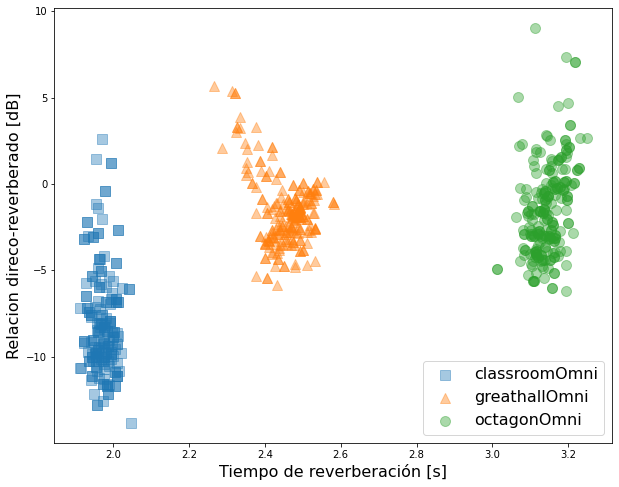

In [3]:
cdict = {'octagonOmni' : 'o', 
        'greathallOmni' : '^',
        'classroomOmni' : 's'}

fig, ax = plt.subplots(1, figsize = (10,8))
for g in np.unique(room):
    ix = np.where(np.array(room)==g)
    ax.scatter(np.array(tr_list)[ix], np.array(drr_list)[ix], marker = cdict[g], label=g, s=100, alpha=0.4)
ax.legend(prop={'size': 16})
ax.set_xlabel('Tiempo de reverberación [s]', fontsize=16)
ax.set_ylabel('Relacion direco-reverberado [dB]', fontsize=16)
plt.show()

# Aumentacion

In [4]:
#TRs a generar 
TR_MIN = 0.1
TR_MAX = 1.2
TR_PASO = 0.2#0.04
trs = []
tr = TR_MIN
while tr < TR_MAX:
    trs.append(np.round(tr,2))
    tr = tr * (1.0+TR_PASO)

#DRRs a generar
DRR_MIN = -3.0
DRR_MAX = 10
DRR_PASO = 0.5
drrs = []
drr = DRR_MIN
while drr < DRR_MAX:
    drrs.append(drr)
    drr = drr + DRR_PASO
print('Tiempos de reverb: ', trs)
print('Relaciones directo-reverberado: ',drrs)

Tiempos de reverb:  [0.1, 0.12, 0.14, 0.17, 0.21, 0.25, 0.3, 0.36, 0.43, 0.52, 0.62, 0.74, 0.89, 1.07]
Relaciones directo-reverberado:  [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5]


### Primera etapa: Tiempos de reverberacion

In [5]:
rir_original, fs = librosa.load(rir_list[0], sr=16000)

rirs_aug = []
for tr_deseado in tqdm.tqdm(trs):
    rir_aug_tr, fs = tr_augmentation(rir_original, fs, tr_deseado)
    rirs_aug.append(rir_aug_tr)

100%|██████████| 14/14 [00:14<00:00,  1.00s/it]


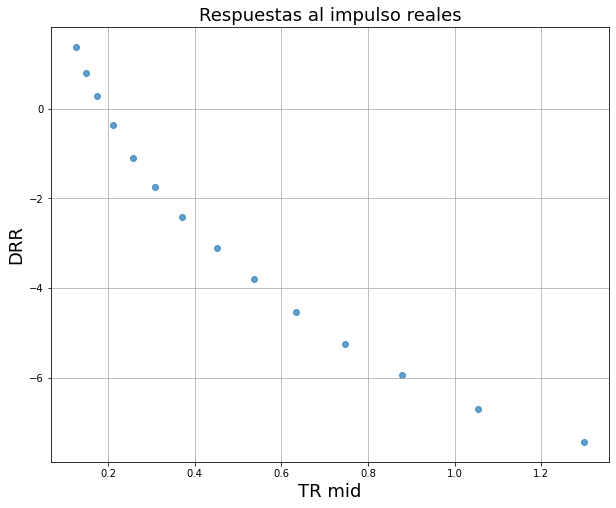

In [6]:
tr_list=[]
drr_list=[]
for impulso in rirs_aug:
    tr, drr = impulse_info(impulso, 16000)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
plt.title('Respuestas al impulso reales', fontsize=18)
plt.xlabel("TR mid", fontsize=18)
plt.ylabel("DRR", fontsize=18)
plt.grid()
plt.show()

### Segunda etapa: DRR

In [7]:
#bloque de aumentacion
rirs = []
for impulso in rirs_aug:
    for drr_deseado in drrs:
        rir_aug_drr = drr_aug(impulso, fs, drr_deseado)
        rirs.append(rir_aug_drr)

TypeError: concatenate() got an unexpected keyword argument 'dtype'

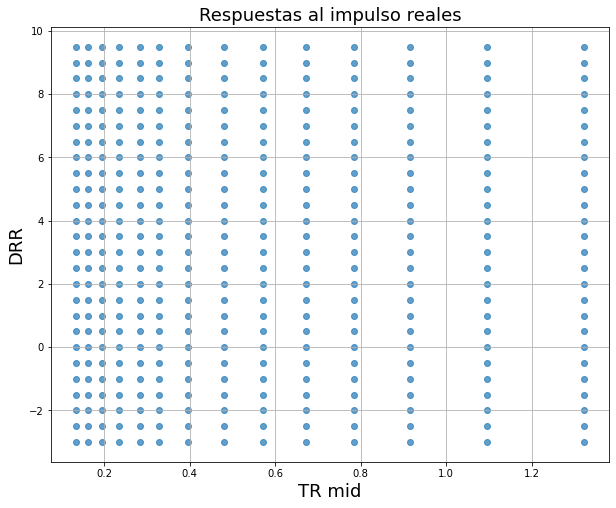

In [12]:
tr_list=[]
drr_list=[]
for impulso in rirs:
    tr, drr = impulse_info(impulso, 16000)
    tr_list.append(tr)
    drr_list.append(drr)
    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
plt.title('Respuestas al impulso reales', fontsize=18)
plt.xlabel("TR mid", fontsize=18)
plt.ylabel("DRR", fontsize=18)
plt.grid()
plt.show()

In [13]:
c = 0
for impulso in tqdm.tqdm(rirs): 
    file_name = 'aumentados/' + str(c) + '.wav'
    sf.write(file_name, impulso, 16000)
    c +=1

100%|██████████| 364/364 [00:00<00:00, 549.44it/s]


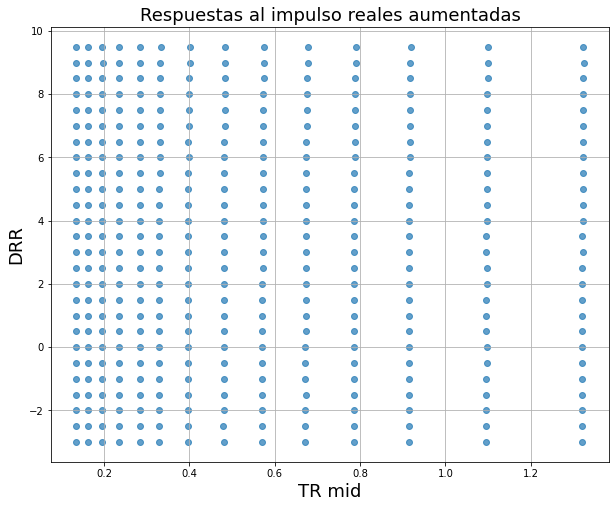

In [14]:
rir_path = 'aumentados/'
rir_list = get_audio_list(rir_path)

tr_list=[]
drr_list=[]

for impulso in rir_list:
    rir, fs = librosa.load(impulso, sr=16000)
    tr, drr = impulse_info(rir, 16000)
    tr_list.append(tr)
    drr_list.append(drr)    
plt.figure(1, figsize = (10,8))
plt.scatter(tr_list, drr_list, alpha = 0.7, marker = 'o')
plt.title('Respuestas al impulso reales aumentadas', fontsize=18)
plt.xlabel("TR mid", fontsize=18)
plt.ylabel("DRR", fontsize=18)
plt.grid()
plt.show()

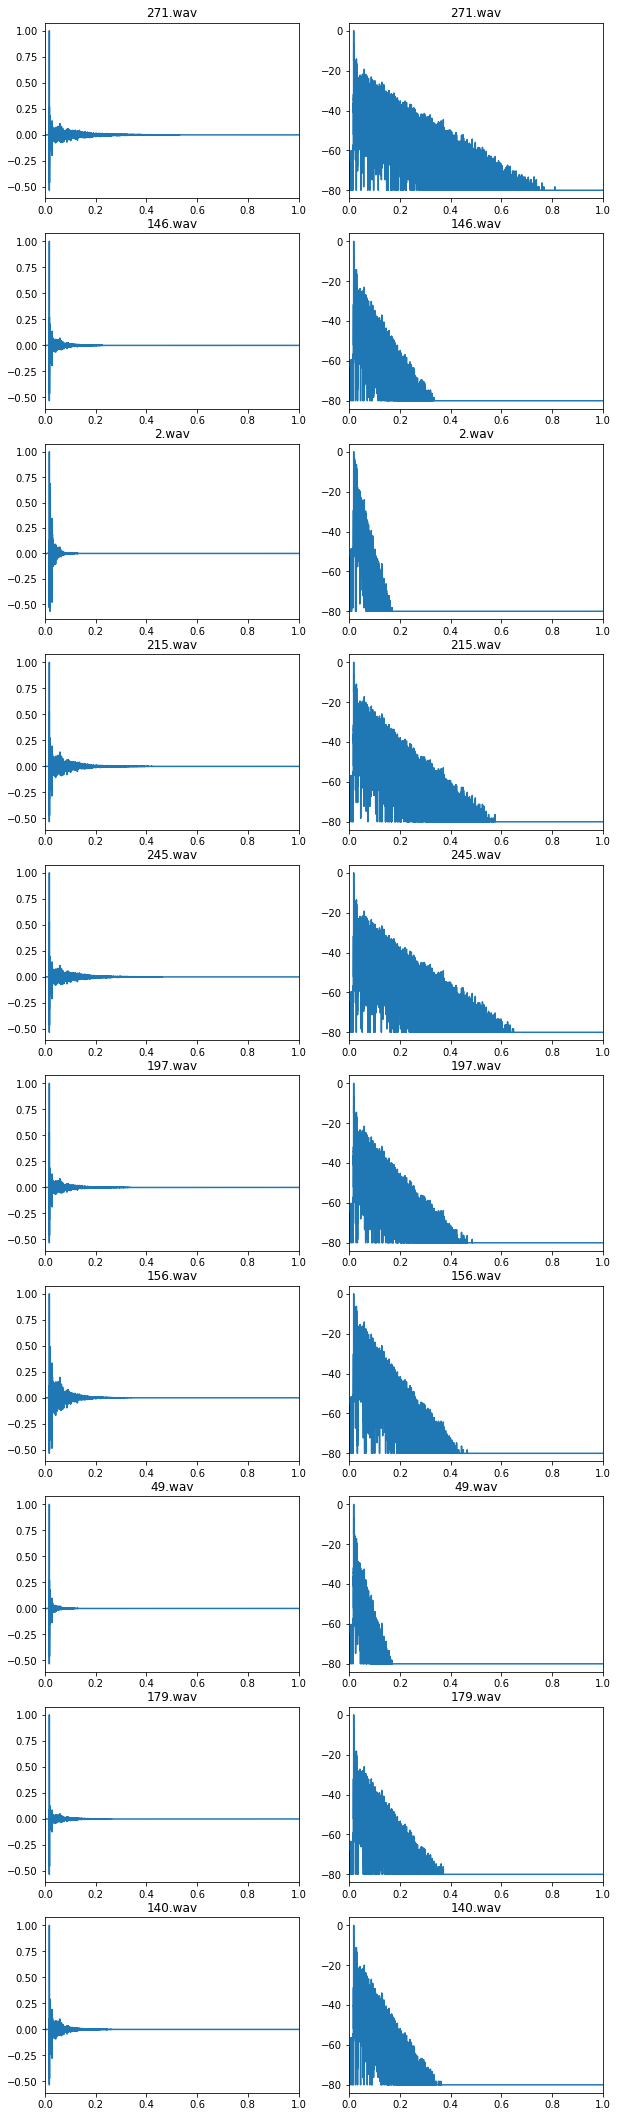

In [15]:
#ploteo algunos impulsos 
rirs_array = []
for path in rir_list:
    rir, fs = librosa.load(path, sr=16000)
    rirs_array.append(rir)

fig, axes = plt.subplots(10,2,figsize=(10,10))
t = np.linspace(0, len(rirs_array[0])/fs, len(rirs_array[0]))

for i, j in enumerate(np.random.randint(0,len(rir_list)-1,size=(10,))):
    axes[i,0].set_title(rir_list[j].split('/')[-1])
    axes[i,0].plot(t,rirs_array[j])
    axes[i,0].set_xlim(0,1)
    
    axes[i,1].set_title(rir_list[j].split('/')[-1])
    axes[i,1].plot(t,librosa.amplitude_to_db(rirs_array[j]))
    axes[i,1].set_xlim(0,1)
    #plot_tr(rir_list[j], axes[i, 2])

plt.subplots_adjust(top=3)